<a href="https://colab.research.google.com/github/cogitare-aude/datasharing/blob/master/1_MLP_Computer_Vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logistic (softmax) regression model

This notebook is organised in two parts:

* the *first part* implements a **logistic regression model from scratch**, as we did for the linear regression model.

* the *second part* makes use of **high-level APIs** for a concise implementation of the same logistic regression model.


## Note for ST456

The following commands are necessary for downloading some helper functions in TensorFlow used by the reference book.

If you get a message saying **you need to restart the runtime**, please **do so before** running the rest of the code.

In [ ]:
!mkdir /content/d2l
! wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/tensorflow.py
!mv tensorflow.py /content/d2l

#!pip install d2l==0.17.1 2>/dev/null

--2022-01-27 21:57:52--  https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/tensorflow.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 74148 (72K) [text/plain]
Saving to: ‘tensorflow.py’

tensorflow.py       100%[===================>]  72.41K  --.-KB/s    in 0.005s  

2022-01-27 21:57:53 (13.5 MB/s) - ‘tensorflow.py’ saved [74148/74148]



In [ ]:
# importing necessary modules
import tensorflow as tf
from IPython import display
from d2l import tensorflow as d2l # helper module from the reference book

## Loading the dataset

This guide uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels), as seen here:

<table>
  <tr><td>
    <img src="https://tensorflow.org/images/fashion-mnist-sprite.png"
         alt="Fashion MNIST sprite"  width="600">
  </td></tr>
  <tr><td align="center">
    <b>Figure 1.</b> <a href="https://github.com/zalandoresearch/fashion-mnist">Fashion-MNIST samples</a> (by Zalando, MIT License).<br/>&nbsp;
  </td></tr>
</table>

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The *labels* are an array of integers, ranging from 0 to 9. These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. 

You can access/import the Fashion MNIST directly from TensorFlow. Here, we are setting up a data iterator with batch size 256.

In [ ]:
# loading data in 256 samples
batch_size = 256

#create training (235) and testing (40) set with batch size = 256 (download data directly from TF)
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

4431872/4422102 [==============================] - 0s 0us/step


## First approach: logistic regression from scratch



## Initializing model parameters

As in our linear regression example,
each example here will be represented by a fixed-length vector.
Each example in the raw dataset is a $28 \times 28$ image.
**We will flatten each image,
treating them as vectors of length 784**, so each pixel will be treated as just another feature.

Recall that in softmax regression,
we have as many outputs as there are classes.
**Because our dataset has 10 classes,
our network will have an output dimension of 10**.
Consequently, our weights will constitute a $784 \times 10$ matrix
and the biases will constitute a $1 \times 10$ row vector.
As with linear regression, we will initialize our weights `W`
with Gaussian noise and our biases to take the initial value 0.


In [ ]:
# input and output dimensions
#input, ie. features (x1...x784), ea. image flattens to become pixels, each pixel = 1-feature, 1 image has 784 pixels
#output, ie. y (where are 10 classes, shirt....pants)
#also 784 row x 10 columns of weights (one weight for ea. class)
#also bias 1 row x 10 column
num_inputs = 784
num_outputs = 10

# initialising model parameters
W = tf.Variable(tf.random.normal(shape=(num_inputs, num_outputs), mean=0, stddev=0.01))
b = tf.Variable(tf.zeros(num_outputs))

W

<tf.Variable 'Variable:0' shape=(784, 10) dtype=float32, numpy=
array([[-1.15743168e-02, -1.27553754e-03, -5.41199977e-03, ...,
        -2.72890669e-03, -1.75411236e-02,  1.72494370e-02],
       [-7.04754889e-03,  1.22556752e-02,  1.12869805e-02, ...,
        -3.84268984e-02, -7.55167683e-04, -2.09961785e-03],
       [ 1.10874102e-02,  4.32833144e-03, -3.49263755e-05, ...,
         1.12616895e-02,  1.81942503e-03, -1.94550259e-03],
       ...,
       [-8.26264545e-03, -8.72868765e-03,  4.50238585e-03, ...,
         1.25187617e-02,  5.27327647e-03, -6.79829158e-04],
       [ 6.65959809e-03,  1.82154514e-02,  1.78031754e-02, ...,
         1.75812673e-02,  7.37626012e-03,  3.42641049e-03],
       [ 5.62647404e-03, -1.18888747e-02, -6.92862179e-03, ...,
        -8.63544736e-03,  1.49093568e-04, -1.62499920e-02]], dtype=float32)>

### Defining the softmax operation

Before implementing the softmax regression model,
let us briefly review how the sum operator works
along specific dimensions in a tensor:

**Given a matrix `X` we can sum over all elements (by default) or only
over elements in the same axis**,
i.e., the same column (axis 0) or the same row (axis 1).

Note that if `X` is a tensor with shape (2, 3)
and we sum over the columns,
the result will be a vector with shape (3,).
When invoking the sum operator,
we can specify to keep the number of axes in the original tensor,
rather than collapsing out the dimension that we summed over.
This will result in a two-dimensional tensor with shape (1, 3).


In [ ]:
# example of sum operator over a tensor
X = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
tf.reduce_sum(X, 0, keepdims=True), tf.reduce_sum(X, 1, keepdims=True)

(<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[5., 7., 9.]], dtype=float32)>,
 <tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[ 6.],
        [15.]], dtype=float32)>)

We are now ready to **implement the softmax operation**.
Recall that softmax consists of three steps:

1. we exponentiate each term (using `exp`);

2. we sum over each row (we have one row per example in the batch)
to get the normalization constant for each example;

3. we divide each row by its normalization constant,
ensuring that the result sums to 1.

Before looking at the code, let us recall
how this looks expressed as an equation:


$$\mathrm{softmax}(\mathbf{X})_{ij} = \frac{\exp(\mathbf{X}_{ij})}{\sum_k \exp(\mathbf{X}_{ik})}$$

The denominator, or normalization constant,
is also sometimes called the *partition function*
(and its logarithm is called the log-partition function).


In [ ]:
# custom implementation of the softmax function
def softmax(X):
    X_exp = tf.exp(X)
    partition = tf.reduce_sum(X_exp, 1, keepdims=True)
    return X_exp / partition  # the broadcasting mechanism is applied here

As you can see, for any random input, **we turn each element into a non-negative number. Moreover, each row sums up to 1**, as is required for a probability.


In [ ]:
X = tf.random.normal((2, 5), 0, 1)
X_prob = softmax(X)
X_prob, tf.reduce_sum(X_prob, 1)

(<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
 array([[0.12505676, 0.43577784, 0.05986837, 0.10240012, 0.2768969 ],
        [0.07492542, 0.3339921 , 0.17761248, 0.19963543, 0.2138346 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.99999994, 1.0000001 ], dtype=float32)>)

Note that while this looks correct mathematically,
we were a bit sloppy in our implementation
because we failed to take precautions against numerical overflow or underflow
due to large or very small elements of the matrix.

---

### Defining the model

Now that we have defined the softmax operation,
we can **implement the softmax regression model**.
The below code defines how the input is mapped to the output through the network.
Note that we flatten each original image in the batch
into a vector using the `reshape` function
before passing the data through our model.


In [ ]:
# custom logistic regression model
def net(X):
    return softmax(tf.matmul(tf.reshape(X, (-1, W.shape[0])), W) + b)

### Defining the loss function

Next, we need to implement the **cross-entropy loss function**. This may be the most common loss function
in all of deep learning because, at the moment,
classification problems far outnumber regression problems.

Recall that cross-entropy takes the negative log-likelihood
of the predicted probability assigned to the true label.
Rather than iterating over the predictions with a Python for-loop
(which tends to be inefficient),
we can pick all elements by a single operator.

Below, we **create sample data `y_hat`
with 2 examples of predicted probabilities over 3 classes and their corresponding labels `y`**. With `y` we know that in the first example the first class is the correct prediction and
in the second example the third class is the ground-truth.
**Using `y` as the indices of the probabilities in `y_hat`**, we pick the probability of the first class in the first example
and the probability of the third class in the second example.


In [ ]:
# example data for demonstrating the cross-entropy loss and the accuracy
y_hat = tf.constant([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y = tf.constant([0, 2])
tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1]))

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.1, 0.5], dtype=float32)>

Now we can **implement the cross-entropy loss function** efficiently with just one line of code.


In [ ]:
# custom implementation of the cross-entropy function
def cross_entropy(y_hat, y):
    return -tf.math.log(
        tf.boolean_mask(y_hat, tf.one_hot(y, depth=y_hat.shape[-1])))

cross_entropy(y_hat, y)

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2.3025851, 0.6931472], dtype=float32)>

### Classification accuracy

Given the predicted probability distribution `y_hat`,
we typically choose the class with the highest predicted probability
whenever we must output a hard prediction.
Indeed, many applications require that we make a choice.
Gmail must categorize an email into "Primary", "Social", "Updates", or "Forums".
It might estimate probabilities internally,
but at the end of the day it has to choose one among the classes.

When predictions are consistent with the label class `y`, they are correct.
**The classification accuracy is the fraction of all predictions that are correct**.
Although it can be difficult to optimize accuracy directly (it is not differentiable),
it is often the performance measure that we care most about,
and we will nearly always report it when training classifiers.

To compute accuracy we do the following:

1. if `y_hat` is a matrix, we assume that the second dimension stores prediction scores for each class.

2. we use `argmax` to obtain the predicted class by the index for the largest entry in each row.

3. then we **compare the predicted class with the ground-truth `y` elementwise**. Since the equality operator `==` is sensitive to data types, we convert `y_hat`'s data type to match that of `y`.

4. the result is a tensor containing entries of 0 (false) and 1 (true). Taking the sum yields the number of correct predictions.


In [ ]:
def accuracy(y_hat, y):  
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = tf.argmax(y_hat, axis=1)
    cmp = tf.cast(y_hat, y.dtype) == y
    return float(tf.reduce_sum(tf.cast(cmp, y.dtype)))

We will continue to use the variables `y_hat` and `y`
defined before
as the predicted probability distributions and labels, respectively.
We can see that the first example's prediction class is 2
(the largest element of the row is 0.6 with the index 2),
which is inconsistent with the actual label, 0.
The second example's prediction class is 2
(the largest element of the row is 0.5 with the index of 2),
which is consistent with the actual label, 2.
Therefore, the classification accuracy rate for these two examples is 0.5.


In [ ]:
# example case
accuracy(y_hat, y) / len(y)

0.5

Similarly, we can **evaluate the accuracy for any model `net` on a dataset**] that is accessed via the data iterator `data_iter`.


In [ ]:
def evaluate_accuracy(net, data_iter): 
    """Compute the accuracy for a model on a dataset."""
    metric = Accumulator(2)  # No. of correct predictions, no. of predictions
    for X, y in data_iter:
        metric.add(accuracy(net(X), y), tf.size(y).numpy())
    return metric[0] / metric[1]

Here `Accumulator` is a utility class to accumulate sums over multiple variables.
In the above `evaluate_accuracy` function,
we create 2 variables in the `Accumulator` instance for storing both
the number of correct predictions and the number of predictions, respectively.
Both will be accumulated over time as we iterate over the dataset.


In [ ]:
# helper class for storing the number of correct predictions and the total number of predictions
class Accumulator:  
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

**Because we initialized the `net` model with random weights,
the accuracy of this model should be close to random guessing**, i.e., 0.1 for 10 classes.


In [ ]:
evaluate_accuracy(net, test_iter)

0.0839

### Training the model

The training loop for softmax regression should look similar to our implementation of linear regression.
Here we refactor the implementation to make it reusable.
First, we define a function to train for one epoch.
Note that `updater` is a general function to update the model parameters,
which accepts the batch size as an argument.
It can be either a wrapper of the `d2l.sgd` function
or a framework's built-in optimization function.


In [ ]:
def train_epoch(net, train_iter, loss, updater):  
    """The training loop"""
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        with tf.GradientTape() as tape:
            y_hat = net(X)
            # Keras implementations for loss takes (labels, predictions)
            # instead of (predictions, labels) that users might implement,
            # e.g. `cross_entropy` that we implemented above
            if isinstance(loss, tf.keras.losses.Loss):
                l = loss(y, y_hat)
            else:
                l = loss(y_hat, y)
        if isinstance(updater, tf.keras.optimizers.Optimizer):
            params = net.trainable_variables
            grads = tape.gradient(l, params)
            updater.apply_gradients(zip(grads, params))
        else:
            updater(X.shape[0], tape.gradient(l, updater.params))
        # Keras loss by default returns the average loss in a batch
        l_sum = l * float(tf.size(y)) if isinstance(
            loss, tf.keras.losses.Loss) else tf.reduce_sum(l)
        metric.add(l_sum, accuracy(y_hat, y), tf.size(y))
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

Before showing the implementation of the training function,
we define *a utility class that plot data in animation*.
This is just for demonstration purposes.

In [ ]:
# helper function for animated data visualisation
class Animator:  
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes,]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: d2l.set_axes(self.axes[
            0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

The following training function then
trains a model `net` on a training dataset accessed via `train_iter`
for multiple epochs, which is specified by `num_epochs`.
At the end of each epoch,
the model is evaluated on a testing dataset accessed via `test_iter`.
We will leverage the `Animator` class to visualize
the training progress.


In [ ]:
def train_model(net, train_iter, test_iter, loss, num_epochs, updater):  
    """Train a model"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        # training step
        train_metrics = train_epoch(net, train_iter, loss, updater)
        # evaluation step
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

As an implementation from scratch,
we use the **minibatch stochastic gradient descent** to optimize the loss function of the model with a learning rate 0.1.


In [ ]:
# custom class for performing model optimisation
class Updater():  
    """For updating parameters using minibatch stochastic gradient descent."""
    def __init__(self, params, lr):
        self.params = params
        self.lr = lr

    def __call__(self, batch_size, grads):
        d2l.sgd(self.params, grads, self.lr, batch_size)

updater = Updater([W, b], lr=0.1)

Now we **train the model with 10 epochs**.
Note that both the number of epochs (`num_epochs`),
and learning rate (`lr`) are adjustable hyperparameters.
By changing their values, we may be able
to increase the classification accuracy of the model.


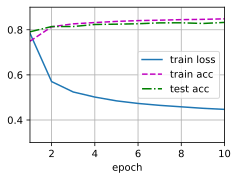

In [ ]:
num_epochs = 10
train_model(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

### Making predictions

Now that training is complete,
our model is ready to **classify some images**.
Given a series of images,
we will compare their actual labels
(first line of text output)
and the predictions from the model
(second line of text output).


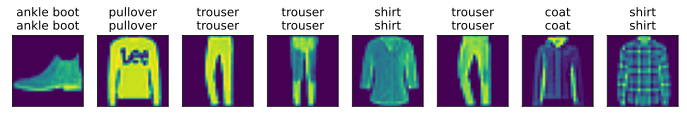

In [ ]:
def predict_image(net, test_iter, n=8):  
    """Predict labels"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(tf.argmax(net(X), axis=1))
    titles = [true + '\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(tf.reshape(X[0:n], (n, 28, 28)), 1, n, titles=titles[0:n])

predict_image(net, test_iter)

### Summary of the first approach

* With softmax regression, we can train models for multiclass classification.
* The training loop of softmax regression is very similar to that in linear regression: retrieve and read data, define models and loss functions, then train models using optimization algorithms. As you will soon find out, most common deep learning models have similar training procedures.

---

## Second approach: logist regression with `keras.Sequential` model

### Initializing model parameters

Remember that **the output layer of softmax regression
is a fully-connected layer**. Therefore, to implement our model,
we just need to add one fully-connected layer
with 10 outputs to our `Sequential` model.
Again, here, the `Sequential` is not really necessary,
but we might as well form the habit since it will be ubiquitous
when implementing deep models.
Again, we initialize the weights at random
with zero mean and standard deviation 0.01.


In [ ]:
net = tf.keras.models.Sequential()
net.add(tf.keras.layers.Flatten(input_shape=(28, 28)))
weight_initializer = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.01)
net.add(tf.keras.layers.Dense(10, kernel_initializer=weight_initializer))

### Softmax implementation revisited

In the previous approach, we calculated our model's output
and then ran this output through the cross-entropy loss.
Mathematically, that is a perfectly reasonable thing to do.
However, from a computational perspective,
exponentiation can be a source of numerical stability issues.

Recall that the softmax function calculates
$\hat y_j = \frac{\exp(o_j)}{\sum_k \exp(o_k)}$,
where $\hat y_j$ is the $j^\mathrm{th}$ element of
the predicted probability distribution $\hat{\mathbf{y}}$
and $o_j$ is the $j^\mathrm{th}$ element of the logits
$\mathbf{o}$.
If some of the $o_k$ are very large (i.e., very positive),
then $\exp(o_k)$ might be larger than the largest number
we can have for certain data types (i.e., *overflow*).
This would make the denominator (and/or numerator) `inf` (infinity)
and we wind up encountering either 0, `inf`, or `nan` (not a number) for $\hat y_j$.
In these situations we do not get a well-defined
return value for cross-entropy.


One trick to get around this is to first subtract $\max(o_k)$
from all $o_k$ before proceeding with the softmax calculation.
You can see that this shifting of each $o_k$ by constant factor
does not change the return value of softmax:

$$
\begin{aligned}
\hat y_j & =  \frac{\exp(o_j - \max(o_k))\exp(\max(o_k))}{\sum_k \exp(o_k - \max(o_k))\exp(\max(o_k))} \\
& = \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}.
\end{aligned}
$$


After the subtraction and normalization step,
it might be possible that some $o_j - \max(o_k)$ have large negative values and thus that the corresponding $\exp(o_j - \max(o_k))$ will take values close to zero.
These might be rounded to zero due to finite precision (i.e., *underflow*),
making $\hat y_j$ zero and giving us `-inf` for $\log(\hat y_j)$.
A few steps down the road in backpropagation,
we might find ourselves faced with a screenful
of the dreaded `nan` results.

Fortunately, we are saved by the fact that
even though we are computing exponential functions,
we ultimately intend to take their log
(when calculating the cross-entropy loss).
By combining these two operators
softmax and cross-entropy together,
we can escape the numerical stability issues
that might otherwise plague us during backpropagation.
As shown in the equation below, we avoid calculating $\exp(o_j - \max(o_k))$
and can use instead $o_j - \max(o_k)$ directly due to the canceling in $\log(\exp(\cdot))$:

$$
\begin{aligned}
\log{(\hat y_j)} & = \log\left( \frac{\exp(o_j - \max(o_k))}{\sum_k \exp(o_k - \max(o_k))}\right) \\
& = \log{(\exp(o_j - \max(o_k)))}-\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)} \\
& = o_j - \max(o_k) -\log{\left( \sum_k \exp(o_k - \max(o_k)) \right)}.
\end{aligned}
$$

We will want to keep the conventional softmax function handy
in case we ever want to evaluate the output probabilities by our model.
But instead of passing softmax probabilities into our new loss function,
we will just **pass the logits and compute the softmax and its log
all at once inside the cross-entropy loss function**.

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Optimization algorithm

Here, we **use minibatch stochastic gradient descent**
with a learning rate of 0.1 as the optimization algorithm.
Note that this is the same as we applied in the linear regression example and it illustrates the general applicability of the optimizers.


In [ ]:
trainer = tf.keras.optimizers.SGD(learning_rate=.1)

### Training the model

Next we **call the training function** to train the model.

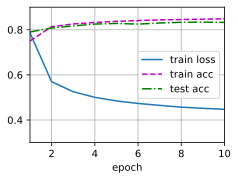

In [ ]:
num_epochs = 10
train_model(net, train_iter, test_iter, loss, num_epochs, trainer)

As before, this algorithm converges to a solution
that achieves a decent accuracy,
albeit this time with fewer lines of code than before.


### Summary of the second approach

* Using high-level APIs, we can implement softmax regression much more concisely.
* From a computational perspective, implementing softmax regression has intricacies. Note that in many cases, a deep learning framework takes additional precautions beyond these most well-known tricks to ensure numerical stability, saving us from even more pitfalls that we would encounter if we tried to code all of our models from scratch in practice.
